In [2]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import pandas as pd 
import sys
import pickle
import itertools
import seaborn as sns
import matplotlib.pyplot as plt

workingdirectory = os.popen('git rev-parse --show-toplevel').read()[:-1]
sys.path.append(workingdirectory)
os.chdir(workingdirectory)

import allensdk.core.json_utilities as ju
from allensdk.core.mouse_connectivity_cache import MouseConnectivityCache

from mcmodels.core import Mask,ModelData,VoxelModelCache
from mcmodels.core.utils import get_structure_id, get_ordered_summary_structures,get_minorstructures,get_loss_paper
from mcmodels.utils import nonzero_unique, unionize
from mcmodels.core.experiment import get_voxeldata_msvd
from mcmodels.models.crossvalidation import get_best_hyperparameters,get_loss_best_hyp,get_loocv_predictions,get_loss
from mcmodels.core.utils import get_cre_status,get_minorstructure_dictionary,get_leaves_ontologicalorder
from mcmodels.core.utils import get_regionalized_normalized_data
from mcmodels.core.utils import get_connectivity
from mcmodels.core.utils import get_ontological_order_leaf
from mcmodels.core.utils import get_nw_loocv,get_wt_inds
from mcmodels.core.utils import get_countvec

/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.linear_model.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.linear_model. Anything that cannot be imported from sklearn.linear_model is now part of the private API.
  warnings.warn(message, FutureWarning)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [3]:
#read data
TOP_DIR = '/Users/samsonkoelle/alleninstitute/mcm_2020/mcm_updated/'
INPUT_JSON = os.path.join(TOP_DIR, 'input_011520.json')
EXPERIMENTS_EXCLUDE_JSON = os.path.join(TOP_DIR, 'experiments_exclude.json')
FILE_DIR = '/Users/samsonkoelle/alleninstitute/mcm_2020/mcm_updated/'
OUTPUT_DIR = os.path.join(FILE_DIR, 'output')

input_data = ju.read(INPUT_JSON)
manifest_file = input_data.get('manifest_file')
manifest_file = os.path.join(TOP_DIR, manifest_file)
experiments_exclude = ju.read(EXPERIMENTS_EXCLUDE_JSON)

#its unclear why the hyperparameters are loaded from the output directory
cache = VoxelModelCache(manifest_file=manifest_file)
major_structures = input_data.get('structures')
major_structure_ids = [get_structure_id(cache, s) for s in major_structures]
data_info = pd.read_excel('/Users/samsonkoelle/alleninstitute/Whole Brain Cre Image Series_curation only.xlsx', 'all datasets curated_070919pull')
data_info.set_index("id", inplace=True)
ontological_order = get_ordered_summary_structures(cache)

mcc = MouseConnectivityCache(manifest_file = '../connectivity/mouse_connectivity_manifest.json')
st = mcc.get_structure_tree()
ai_map = st.get_id_acronym_map()
ia_map = {value: key for key, value in ai_map.items()}

#regionalize voxel model: compare with regional model
#regional parameters
cre = None
eid_set=None
high_res=False
threshold_injection = False

COARSE_STRUCTURE_SET_ID = 2
DEFAULT_STRUCTURE_SET_IDS = tuple([COARSE_STRUCTURE_SET_ID])
tree = cache.get_structure_tree()
default_structures = tree.get_structures_by_set_id(DEFAULT_STRUCTURE_SET_IDS)
default_structure_ids = [st['id'] for st in default_structures if st['id'] != 934]
#cre= True

In [4]:
msvds = {}
#gammas = np.asarray([0.1])
for sid in major_structure_ids:
    print(sid)
    voxel_data = ModelData(cache, sid)
    print(cre)
    experiment_ids = voxel_data.get_experiment_ids(experiments_exclude=experiments_exclude, cre=cre)
    experiment_ids = np.asarray(list(experiment_ids))    
    msvd = get_voxeldata_msvd(cache, sid,experiments_exclude,default_structure_ids,cre)
    #msvd.l2losses, msvd.paperlosses,msvd.normspredict,msvd.normtrue = single_region_cv(msvd, gammas)
    msvds[sid]  = msvd

512
None
703
None
1089
None
1097
None
315
None
313
None
354
None
698
None
771
None
803
None
477
None
549
None


In [5]:
#changed ipsi, contra_key

In [6]:
creline = get_cre_status(data_info, msvds)
experiments_minor_structures = get_minorstructure_dictionary(msvds, data_info)
leavves = get_leaves_ontologicalorder(msvd, ontological_order)

# contra_key = msvd.experiments[list(msvd.experiments.keys())[0]].projection_mask.get_key(structure_ids=leavves, hemisphere_id=1)
# ipsi_key = msvd.experiments[list(msvd.experiments.keys())[0]].projection_mask.get_key(structure_ids=leavves, hemisphere_id=2)

key = list(msvd.experiments.keys())[0]
contra_key = msvd.experiments[key].projection_mask.get_key(structure_ids=ontological_order, hemisphere_id=1)
ipsi_key = msvd.experiments[key].projection_mask.get_key(structure_ids=ontological_order, hemisphere_id=2)

msvds = get_regionalized_normalized_data(msvds,cache, ontological_order,ipsi_key,contra_key,experiments_minor_structures)
gammas = np.asarray([0.1,.5,1,2,10])
wt_2ormore = get_wt_inds(creline)

for sid in major_structure_ids:
    #print(msvds[sid].projections.shape[0], len(wt_2ormore[sid]))
    msvds[sid].loocv_predictions_all = get_nw_loocv(msvds[sid], np.asarray(list(range(msvds[sid].projections.shape[0]))), get_loocv_predictions, gammas)
    msvds[sid].loocv_predictions_wt = get_nw_loocv(msvds[sid], wt_2ormore[sid], get_loocv_predictions, gammas)

homo_loocv_predictions_all = {}
homo_loocv_predictions_wt = {}
homo_reg_proj_vcount_norm_renorms= {}
for sid in major_structure_ids:
    homo_loocv_predictions_all[sid ] = msvds[sid].loocv_predictions_all
    homo_loocv_predictions_wt[sid ] = msvds[sid].loocv_predictions_wt
    homo_reg_proj_vcount_norm_renorms[sid ] = msvds[sid].reg_proj_vcount_norm_renorm
    
inds_good = {}
for sid in major_structure_ids:
    inds_good[sid] = np.asarray(list(range(msvds[sid].injections.shape[0])))
    
a= [list(range(5))]
keys = np.asarray(list(itertools.product(*a)))

#sel_ga_wt = get_best_hyperparameters(losses_wts,keys)

losses_all = get_loss(homo_reg_proj_vcount_norm_renorms, homo_loocv_predictions_all,pred_ind = inds_good, true_ind = inds_good,keys = keys)
losses_wts = get_loss(homo_reg_proj_vcount_norm_renorms, homo_loocv_predictions_wt,pred_ind = wt_2ormore, true_ind = wt_2ormore, keys = keys)
losses_allwts = get_loss(homo_reg_proj_vcount_norm_renorms, homo_loocv_predictions_all,pred_ind = wt_2ormore, true_ind = wt_2ormore, keys = keys)

sel_ga_all = get_best_hyperparameters(losses_all,keys)
sel_ga_allwt = sel_ga_all#get_gamma(losses_allwt,keys)

mean_nw_all = get_loss_best_hyp(losses_all, sel_ga_all)
mean_nw_allwt = get_loss_best_hyp(losses_allwts, sel_ga_all)
#mean_nw_wt = get_loss_best_hyp(losses_all, sel_ga_wt)

print(mean_nw_all)
print(mean_nw_allwt)

losses = np.asarray([mean_nw_all, 
           mean_nw_allwt]).transpose()
losses2 = losses[[4,7,2,1,10,9,11,3,5,8,6,0]]
loss =pd.DataFrame(losses2, columns = ['all','allwt'])


/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:15: RuntimeWarning: divide by zero encountered in true_divide
  weights_i = weights[i] / weights[i][otherindices].sum()
/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:15: RuntimeWarning: invalid value encountered in true_divide
  weights_i = weights[i] / weights[i][otherindices].sum()
/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:15: RuntimeWarning: divide by zero encountered in true_divide
  weights_i = weights[i] / weights[i][otherindices].sum()
/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:15: RuntimeWarning: invalid value encountered in true_divide
  weights_i = weights[i] / weights[i][otherindices].sum()
/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalida

/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:15: RuntimeWarning: divide by zero encountered in true_divide
  weights_i = weights[i] / weights[i][otherindices].sum()
/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:15: RuntimeWarning: invalid value encountered in true_divide
  weights_i = weights[i] / weights[i][otherindices].sum()


0
1
2
3
4
5
6
7
8
9
10
11
[0.90097783 0.77737892 0.35946378 0.29377341 0.43029092 0.47135974
 0.40976477 0.44626504 0.45657043 0.53027727 0.69085557 0.42870434]
[1.20922247        nan 0.26124218 0.26865134 0.28385839 0.26417285
 0.39617524 0.2177794  0.57632538 0.50071204 0.48259818 0.34852249]


/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:242: RuntimeWarning: Mean of empty slice
  output[m] = np.nanmean(losses[sid][hyps[m], :])


In [27]:
def get_loocv_predictions_code(projections, centroids, gamma, codes):
    
    unique_codes = np.unique(codes)
    predictions = np.empty(projections.shape)
    for c in range(len(unique_codes)):
        code_ind = np.where(codes == unique_codes[c])[0]
        predictions[code_ind] = get_loocv_predictions(projections[code_ind], centroids[code_ind], gamma)
    return(predictions)

In [26]:
get_loocv_predictions_code(projections, centroids, gamma, codes)

(2, 36, 448962)

In [ ]:
def get_loocv_predictions(projections, centroids, gamma):
    projections = np.asarray(projections, dtype=np.float32)
    nexp = centroids.shape[0]
    predictions = projections.copy()
    weights = get_weights(centroids, gamma)

    for i in range(nexp):
        otherindices = np.setdiff1d(np.asarray(list(range(nexp))), i)
        weights_i = weights[i] / weights[i][otherindices].sum()
        weights_i[i] = 0
        weights_i = np.asarray(weights_i, dtype=np.float32)
        pred = np.dot(weights_i, projections)
        predictions[i] = pred

    return (predictions)

In [22]:
msvds[512].loocv_predictions_all[0][35]

array([1.28217172e-02, 1.34948001e-04, 2.22280785e-03, 1.83560420e-04,
       1.27192311e-13, 9.14863031e-03, 5.95984648e-06, 2.09694772e-04,
       1.17684238e-20, 1.47223109e-05, 2.91581500e-06, 5.31769008e-04,
       4.91022947e-04, 1.13758550e-03, 7.66999801e-06, 7.25848877e-05,
       3.01883028e-05, 4.60309195e-07, 1.05717474e-04, 1.49965489e-14,
       4.22409008e-04, 3.10974594e-14, 5.47652431e-02, 4.57238610e-04,
       3.60373611e-04, 9.71956586e-04, 1.09982106e-03, 2.28986586e-03,
       5.53727441e-04, 1.18876953e-04, 7.61542242e-06, 7.87677884e-04,
       8.80402571e-04, 2.41155193e-14, 8.71392491e-04, 2.82516176e-05,
       4.12458320e-07, 9.14839678e-04, 1.08483923e-03, 2.13488107e-04,
       2.54496560e-03, 3.99554410e-05, 8.55115723e-05, 1.91156523e-05,
       3.70269525e-04, 3.77319084e-04, 4.23083664e-04, 1.18402968e-05,
       1.81780953e-04, 1.11338326e-04, 1.91640444e-04, 3.73823400e-06,
       2.87719668e-05, 9.02561733e-05, 2.15345339e-04, 1.24941595e-04,
      

In [19]:
sel_ga_all

array([[0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [4],
       [4],
       [0],
       [0],
       [1]])

In [20]:
msvds[512].centroids

array([[113.79714597,  37.19812007,  73.25179841],
       [119.84782877,  29.33587775,  86.42990591],
       [115.49059377,  28.39891452,  63.94150208],
       [126.37081335,  44.91567587,  83.01036918],
       [119.05446454,  21.38798254,  78.74039658],
       [115.92742014,  19.83154078,  78.85062681],
       [110.312766  ,  41.50846429,  82.92949299],
       [111.94070294,  17.9898812 ,  80.77383697],
       [113.69525638,  18.52916955,  62.65550172],
       [108.96202339,  24.8844757 ,  61.30064946],
       [117.86440511,  44.07420475,  62.80937688],
       [116.35256493,  17.70501654,  66.31235392],
       [114.05417213,  39.16545324,  73.96264669],
       [119.32762348,  23.83350449,  81.44339851],
       [107.02300531,  21.50030048,  78.60513024],
       [110.77742109,  21.66948618,  79.60294935],
       [114.21213742,  39.11112051,  73.30095355],
       [108.78352543,  34.48544363,  60.65449556],
       [117.7779253 ,  20.02962006,  80.36791864],
       [110.15867081,  20.35245

In [13]:
losses_allwts[512].shape

(5, 12)

In [18]:
losses_all[512][0]

array([0.34166852, 1.02488828, 0.42989263, 1.91087252, 0.36760405,
       0.37124295, 0.37403708, 0.2014561 , 1.04634096, 1.64569044,
       1.92118108, 0.21727991, 0.12731065, 1.31945597, 1.05709393,
       0.03828835, 0.22249691, 1.64916624, 0.35433854, 0.77214151,
       1.55328598, 1.17894373, 1.94892277, 0.42803765, 0.63522155,
       0.64247565, 0.60203188, 1.01437851, 0.39306433, 0.56134609,
       1.85766596, 0.53469826, 1.57203338, 1.32763251, 1.24350352,
       1.54951339])

In [16]:
# exps = np.asarray(data_info.index.values , dtype = np.int)
# creline = {}
# for sid in major_structure_ids:
#     msvd = msvds[sid]
#     experiment_ids = np.asarray(list(msvd.experiments.keys()))
#     nexp = len(experiment_ids)
#     creline[sid] = np.zeros(nexp, dtype = object)
#     for i in range(len(experiment_ids)):
#         index = np.where(exps == experiment_ids[i])[0][0]
#         creline[sid][i] = data_info['transgenic-line'].iloc[index]
ngam  = 5
#inds_bad are where there is no injection
#we can use these to train but shouldnt to evaluate
#the 'wt_ind' should just be 'eval_ind'
inds_bad = {}
inds_good = {}
for sid in major_structure_ids:
    injections = msvds[sid].injections 
    inds_bad[sid] = np.where(injections.sum(axis = 1) == 0.)[0]
    inds_good[sid] = np.where(injections.sum(axis = 1) > 0.)[0]
    
nms = len(major_structure_ids)
#ngam = len(gammas)
wt_2ormore = {}
losses_reg_norm = np.zeros((nms,ngam))
inds_good_wt = {}
inds_good_wtsub = {}
for m in range(nms):
    sid = major_structure_ids[m]
    wt_inds = np.where(creline[sid] == 'C57BL/6J')[0]
    wt_2ormore[sid] = np.asarray([])
    #wt_2ormore is the indices of when there are 2 or more wild types
    if len(wt_inds) > 1:
        wt_2ormore[sid] = np.append(wt_2ormore[sid],wt_inds)
    wt_2ormore[sid] = np.asarray(wt_2ormore[sid], dtype = int)
    inds_good_wt[sid] = np.intersect1d(wt_2ormore[sid], inds_good[sid])
    inds_good_wtsub[sid] = np.where(np.isin(wt_2ormore[sid], inds_good[sid]))[0]

In [17]:
inds_bad

{512: array([], dtype=int64),
 703: array([], dtype=int64),
 1089: array([], dtype=int64),
 1097: array([], dtype=int64),
 315: array([], dtype=int64),
 313: array([], dtype=int64),
 354: array([], dtype=int64),
 698: array([], dtype=int64),
 771: array([], dtype=int64),
 803: array([], dtype=int64),
 477: array([], dtype=int64),
 549: array([], dtype=int64)}

In [11]:
print(sel_ga_all,'a', sel_ga_allwt)

[[0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [4]
 [4]
 [0]
 [0]
 [1]] a [[0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [4]
 [4]
 [0]
 [0]
 [1]]


In [7]:
loss

,all,allwt
0,0.430291,0.283858
1,0.446265,0.217779
2,0.359464,0.261242
3,0.777379,NaN
4,0.690856,0.482598
5,0.530277,0.500712
6,0.428704,0.348522
7,0.293773,0.268651
8,0.471360,0.264173
9,0.456570,0.576325


In [10]:

name = 'leafsum_nw_0720'
expfolder = workingdirectory +   '/data/' + name
os.mkdir(expfolder)
loss.to_csv(expfolder + 'losses')

#msvds_save = {}
for sid in major_structure_ids:
    np.save(expfolder +'/'+ str(sid) + 'reg_proj_vcount_norm_renorm',msvds[sid].reg_proj_vcount_norm_renorm)
    np.save(expfolder +'/'+ str(sid) + 'loocv_predictions_all',msvds[sid].loocv_predictions_all)
    np.save(expfolder +'/'+ str(sid) + 'loocv_predictions_wt',msvds[sid].loocv_predictions_wt)
    
with open(expfolder +'/'+ 'wt_2ormore_base.pickle', 'wb') as handle:
    pickle.dump(wt_2ormore, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open('data/info/leafs.pickle', 'rb') as handle:
    leafs = pickle.load(handle)
    
ontological_order_leaf = get_ontological_order_leaf(leafs, ontological_order, st)
source_exp_countvec, source_exp_countvec_wt = get_countvec(ontological_order, ia_map, creline, experiments_minor_structures)
hyperparameters = gammas[sel_ga_all]
#leavves v ontological_order_leaf
#leavves is the leaves associated with ontological_order
#ontological_order_leaf is the leaves that are actually present
#leafs is the dictionary with the leaves of the experiments
df = get_connectivity(msvds, cache, ia_map, hyperparameters, ontological_order_leaf, ontological_order, leafs, creline,experiments_minor_structures, ipsi_key, contra_key)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
42
43
44
45
46
48
49
51
53
54
56
57
60
61
62
63
64
65
66
69
70
72
73
74
76
77
78
84
86
87
88
89
91
92
93
94
96
97
98
100
102
106
107
108
109
112
113
116
117
118
119
120
122
123
124
126
127
129
130
132
134
135
136
138
141
144
145
151
154
157
158
160
162
163
165
166
167
168
169
172
174
175
176
177
178
183
184
186
187
188
189
192
196
197
204
206
209
210
212
213
216
217
218
221
222
223
225
226
227
230
232
233
235
237
239
240
242
243
246
247
249
250
253
257
260
265
266
269
273
275
276
279
281
282
283
284
286
288
289
290
0
1
2
3
4
5
6
7
8
9
10
11
12
0
1
2
3
4
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81


/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/core/utils.py:99: RuntimeWarning: invalid value encountered in true_divide
  weights = weights / weights.sum(axis=0)


1
2
3


/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/core/utils.py:99: RuntimeWarning: invalid value encountered in true_divide
  weights = weights / weights.sum(axis=0)


4


/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/core/utils.py:99: RuntimeWarning: invalid value encountered in true_divide
  weights = weights / weights.sum(axis=0)


5


/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/core/utils.py:99: RuntimeWarning: invalid value encountered in true_divide
  weights = weights / weights.sum(axis=0)


6
7


/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/core/utils.py:99: RuntimeWarning: invalid value encountered in true_divide
  weights = weights / weights.sum(axis=0)


8


/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/core/utils.py:99: RuntimeWarning: invalid value encountered in true_divide
  weights = weights / weights.sum(axis=0)


0


/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/core/utils.py:99: RuntimeWarning: invalid value encountered in true_divide
  weights = weights / weights.sum(axis=0)


1


/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/core/utils.py:99: RuntimeWarning: invalid value encountered in true_divide
  weights = weights / weights.sum(axis=0)


2
3
4


/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/core/utils.py:99: RuntimeWarning: invalid value encountered in true_divide
  weights = weights / weights.sum(axis=0)


5


/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/core/utils.py:99: RuntimeWarning: invalid value encountered in true_divide
  weights = weights / weights.sum(axis=0)


6
7
8
9
10
11


/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/core/utils.py:99: RuntimeWarning: invalid value encountered in true_divide
  weights = weights / weights.sum(axis=0)


12
0
1
2
3
4
5
6
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27


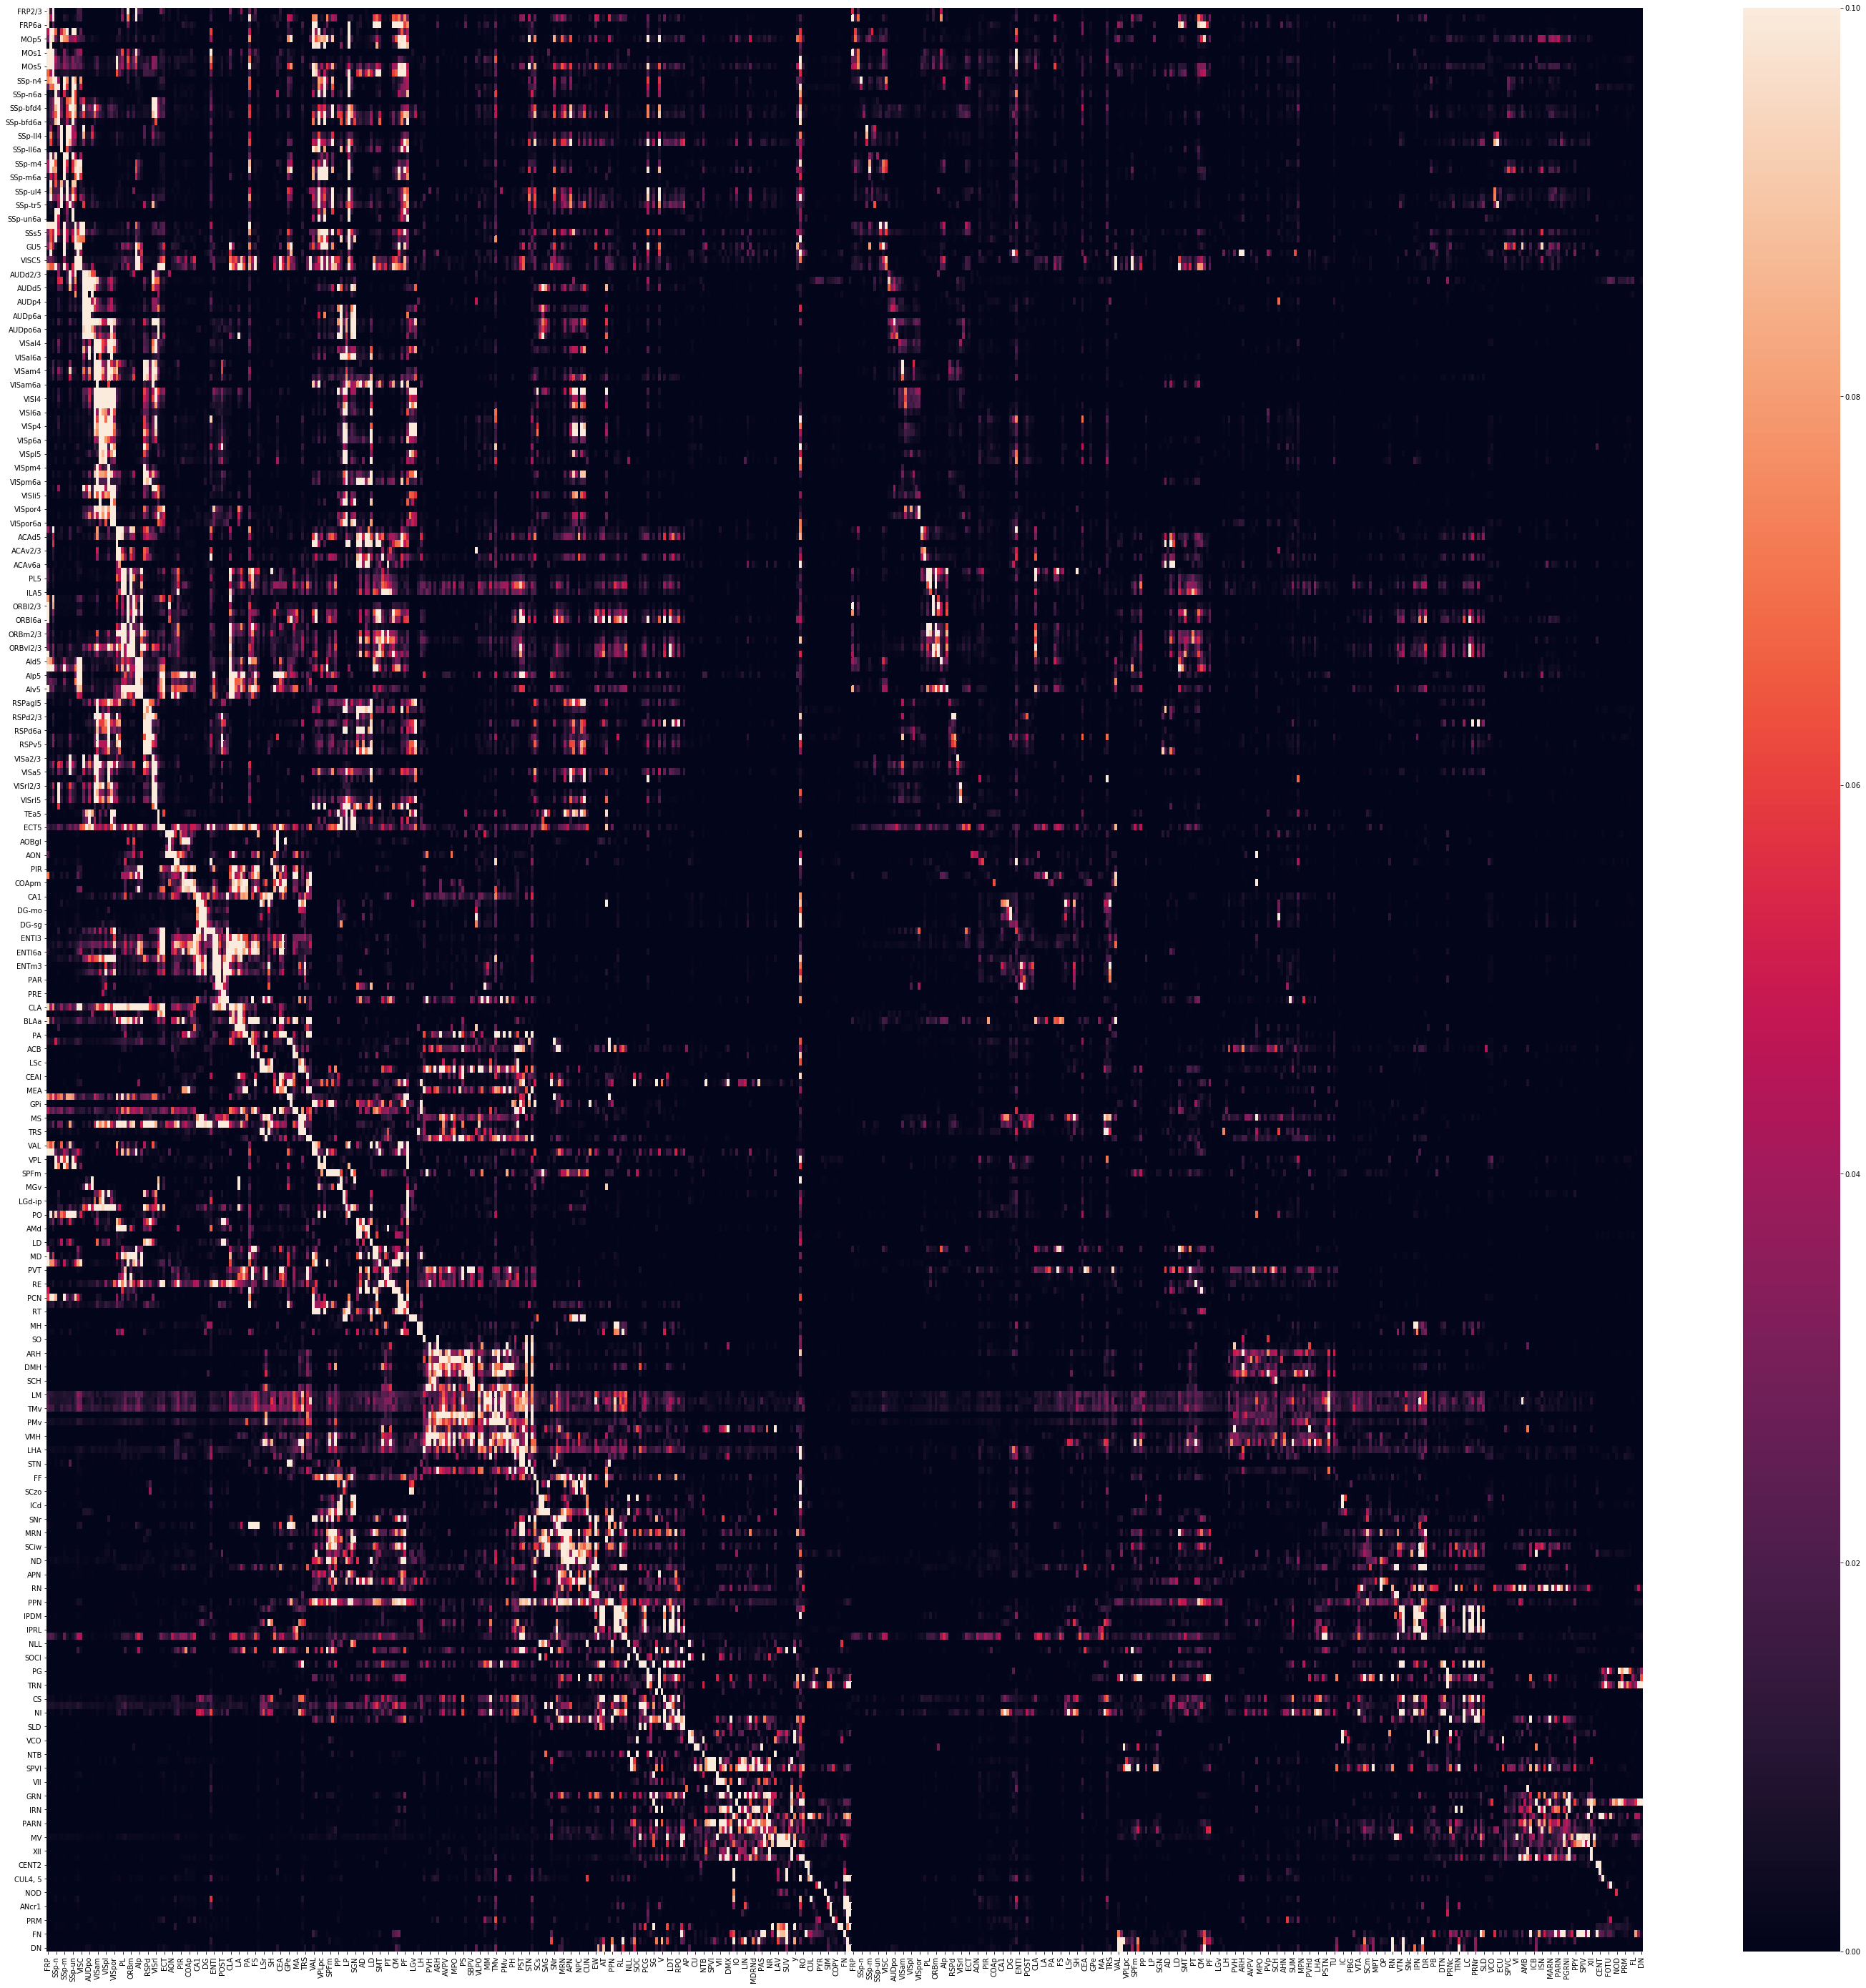

In [12]:
fig, ax = plt.subplots(0,figsize = (50,50))
sns.heatmap(df, vmax = 0.1, vmin=0.)

In [22]:
# data_info = pd.read_excel('/Users/samsonkoelle/alleninstitute/Whole Brain Cre Image Series_curation only.xlsx', 'all datasets curated_070919pull')
# data_info.set_index("id", inplace=True)
# ontological_order = get_ordered_summary_structures(cache)

# exps = np.asarray(data_info.index.values , dtype = np.int)
# creline = {}
# for sid in major_structure_ids:
#     msvd = msvds[sid]
#     experiment_ids = np.asarray(list(msvd.experiments.keys()))
#     nexp = len(experiment_ids)
#     creline[sid] = np.zeros(nexp, dtype = object)
#     for i in range(len(experiment_ids)):
#         index = np.where(exps == experiment_ids[i])[0][0]
#         creline[sid][i] = data_info['transgenic-line'].iloc[index]
        
# experiments_minor_structures = {}
# for sid in major_structure_ids:
#     msvd = msvds[sid]
#     eids = np.asarray(list(msvd.experiments.keys()))
#     experiments_minor_structures[sid] = get_minorstructures(eids, data_info)

In [24]:
# key = list(msvd.experiments.keys())[0]
# contra_key = msvd.experiments[key].projection_mask.get_key(structure_ids=ontological_order, hemisphere_id=1)
# ipsi_key = msvd.experiments[key].projection_mask.get_key(structure_ids=ontological_order, hemisphere_id=2)

# cre = None
# l2losses = {}
# paperlosses = {}
# normspredict = {}
# normtrue = {}
# for sid in major_structure_ids:
#     #print()
#     msvd = msvds[sid]
#     nexp = msvd.projections.shape[0]
#     ngam = 1
    
#     l2losses[sid] = np.zeros((ngam,nexp))
#     paperlosses[sid] = np.zeros((ngam,nexp))
#     normspredict[sid] = np.zeros((ngam,nexp))
#     normtrue[sid] = np.zeros(nexp)

#     minor_structures = np.unique(experiments_minor_structures[sid])
#     nmins = len(minor_structures)
    
#     projections = msvd.projections
#     ipsi_proj = unionize(projections, ipsi_key)
#     contra_proj = unionize(projections, contra_key)
#     reg_proj = np.hstack([ipsi_proj, contra_proj])
#     msvd.reg_proj = reg_proj
    
#     ipsi_target_regions, ipsi_target_counts = nonzero_unique(ipsi_key, return_counts=True)
#     contra_target_regions, contra_target_counts = nonzero_unique(contra_key, return_counts=True)
#     target_counts = np.concatenate([ipsi_target_counts, contra_target_counts])
#     reg_proj_vcount_norm = np.divide(reg_proj, target_counts[np.newaxis, :])
#     msvd.reg_proj_vcount_norm = reg_proj_vcount_norm

#     source_mask = Mask.from_cache(cache, structure_ids=[sid], hemisphere_id=2)
#     source_key = source_mask.get_key(structure_ids=ontological_order)  
#     source_target_counts, source_target_counts =nonzero_unique(source_key, return_counts=True)
    
#     injections = msvd.injections
#     reg_ipsi_inj = unionize(injections, source_key)
#     msvd.reg_inj = reg_ipsi_inj  
#     reg_inj_vcount_norm = np.divide(reg_ipsi_inj, source_target_counts[np.newaxis, :])
#     msvd.reg_inj_vcount_norm = reg_inj_vcount_norm

In [50]:
msvd.reg_proj_vcount_norm.shape

(83, 577)

In [25]:
major_structures = input_data.get('structures')
major_structure_ids = [get_structure_id(cache, s) for s in major_structures]
#gammas = np.asarray([0.1,.5,1,2,10])


In [26]:
gammas = np.asarray([0.1,.5,1,2,10])

In [27]:
nms = len(major_structure_ids)
ngam = len(gammas)
wt_2ormore = {}
losses_reg_norm = np.zeros((nms,ngam))
for m in range(12):
    sid = major_structure_ids[m]
    projections = msvds[sid].reg_proj_vcount_norm
    projections = projections / np.expand_dims(np.linalg.norm(projections, axis = 1),1)
    msvds[sid].reg_proj_vcount_norm_renorm = projections
    centroids = msvds[sid].centroids
    nreg = projections.shape[1]
    nexp = projections.shape[0]
    
    nfeat = projections.shape[1]
    #ncomps = np.append(np.asarray(np.linspace(1, nfeat / 10, 5), dtype = int),nfeat - 1)
    #nalpha = len(alphas)
    
    #msvds[sid].loocv_predictions_all = np.zeros((ngam, len(ncomps),nalpha, nexp, nreg))
    #msvds[sid].loocv_predictions_wt = np.zeros((ngam, len(ncomps),nalpha, nexp, nreg))
    msvds[sid].loocv_predictions_wt = np.zeros((ngam, nexp, nreg))
    msvds[sid].loocv_predictions_all = np.zeros((ngam, nexp, nreg))
    wt_inds = np.where(creline[sid] == 'C57BL/6J')[0]
    wt_2ormore[sid] = np.asarray([])
    
    
    for g in range(ngam):
        print(g,'g')
        #for c in range(len(ncomps)):
#            print(c,'c')
            #for a in range(nalpha):
#                print(a,'a')
#         losses_reg_norm[m,g] = get_loss_paper(projections[wt_inds], loocv_predictions[wt_inds])
        msvds[sid].loocv_predictions_all[g] = get_loocv_predictions(projections, centroids, gammas[g])
        if len(wt_inds) > 1:
            msvds[sid].loocv_predictions_wt[g, wt_inds] = get_loocv_predictions(projections[wt_inds], centroids[wt_inds], gammas[g])
            if g == 0:
                wt_2ormore[sid] = np.append(wt_2ormore[sid],wt_inds)
    wt_2ormore[sid] = np.asarray(wt_2ormore[sid], dtype = int)

0 g
1 g
2 g
3 g
4 g
0 g
1 g
2 g
3 g
4 g
0 g
1 g
2 g
3 g
4 g
0 g
1 g
2 g
3 g
4 g
0 g


/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:14: RuntimeWarning: divide by zero encountered in true_divide
  weights_i = weights[i] / weights[i][otherindices].sum()
/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:14: RuntimeWarning: invalid value encountered in true_divide
  weights_i = weights[i] / weights[i][otherindices].sum()
/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:14: RuntimeWarning: divide by zero encountered in true_divide
  weights_i = weights[i] / weights[i][otherindices].sum()
/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:14: RuntimeWarning: invalid value encountered in true_divide
  weights_i = weights[i] / weights[i][otherindices].sum()
/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalida

1 g
2 g
3 g
4 g


/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:14: RuntimeWarning: divide by zero encountered in true_divide
  weights_i = weights[i] / weights[i][otherindices].sum()
/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:14: RuntimeWarning: invalid value encountered in true_divide
  weights_i = weights[i] / weights[i][otherindices].sum()
/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:14: RuntimeWarning: divide by zero encountered in true_divide
  weights_i = weights[i] / weights[i][otherindices].sum()
/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:14: RuntimeWarning: invalid value encountered in true_divide
  weights_i = weights[i] / weights[i][otherindices].sum()
/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalida

0 g
1 g
2 g
3 g
4 g
0 g
1 g
2 g
3 g
4 g
0 g
1 g
2 g
3 g
4 g
0 g
1 g
2 g
3 g
4 g
0 g
1 g
2 g
3 g
4 g
0 g
1 g
2 g
3 g
4 g
0 g
1 g
2 g
3 g
4 g


/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:14: RuntimeWarning: divide by zero encountered in true_divide
  weights_i = weights[i] / weights[i][otherindices].sum()
/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:14: RuntimeWarning: invalid value encountered in true_divide
  weights_i = weights[i] / weights[i][otherindices].sum()


In [32]:
exps = np.asarray(data_info.index.values , dtype = np.int)
creline = {}
for sid in major_structure_ids:
    msvd = msvds[sid]
    experiment_ids = np.asarray(list(msvd.experiments.keys()))
    nexp = len(experiment_ids)
    creline[sid] = np.zeros(nexp, dtype = object)
    for i in range(len(experiment_ids)):
        index = np.where(exps == experiment_ids[i])[0][0]
        creline[sid][i] = data_info['transgenic-line'].iloc[index]

#inds_bad are where there is no injection
#we can use these to train but shouldnt to evaluate
#the 'wt_ind' should just be 'eval_ind'
inds_bad = {}
inds_good = {}
for sid in major_structure_ids:
    injections = msvds[sid].injections 
    inds_bad[sid] = np.where(injections.sum(axis = 1) == 0.)[0]
    inds_good[sid] = np.where(injections.sum(axis = 1) > 0.)[0]
    
nms = len(major_structure_ids)
#ngam = len(gammas)
wt_2ormore = {}
losses_reg_norm = np.zeros((nms,ngam))
inds_good_wt = {}
inds_good_wtsub = {}
for m in range(nms):
    sid = major_structure_ids[m]
    wt_inds = np.where(creline[sid] == 'C57BL/6J')[0]
    wt_2ormore[sid] = np.asarray([])
    #wt_2ormore is the indices of when there are 2 or more wild types
    if len(wt_inds) > 1:
        wt_2ormore[sid] = np.append(wt_2ormore[sid],wt_inds)
    wt_2ormore[sid] = np.asarray(wt_2ormore[sid], dtype = int)
    inds_good_wt[sid] = np.intersect1d(wt_2ormore[sid], inds_good[sid])
    inds_good_wtsub[sid] = np.where(np.isin(wt_2ormore[sid], inds_good[sid]))[0]

In [33]:
    
def get_loss(true_dict, prediction_dict,pred_ind = None, true_ind = None, keys = None):
    
    output = {}
    major_structure_ids = list(prediction_dict.keys())
    nms = len(major_structure_ids)
    ngam = prediction_dict[major_structure_ids[0]].shape[0]
    nalph = prediction_dict[major_structure_ids[0]].shape[1]
    for m in range(nms):
        sid = major_structure_ids[m]
        if pred_ind == None:
            #prediction_dict and true_dict will contain predictions for 'bad' experiments with no recorded injection
            #when we have the wild type predictions, the subset is what is good among the wild types
            #so 'true' subsetting is always good, since it is w.r.t. the full injection
            #but prediction needs good w.r.t. wt
            pind = np.asarray(list(range(prediction_dict[sid].shape[1])), dtype = int)
        else:
            pind = pred_ind[sid]
        if true_ind == None:
            tind = np.asarray(list(range(true_dict[sid].shape[0])), dtype = int)
        else:
            tind = true_ind[sid]
        
        nexp = len(pind)
        
        output[sid] = np.zeros(np.append([len(np.unique(keys[:,i])) for i in range(keys.shape[1])], nexp))

        for j in range(keys.shape[0]):
            output[sid][tuple(keys[j])] = np.asarray([get_loss_paper(true_dict[sid][tind[i]], prediction_dict[sid][tuple(keys[j])][pind[i]]) for i in range(nexp)]) 
                
    return(output)

In [34]:
homo_loocv_predictions_all = {}
homo_loocv_predictions_wt = {}
homo_reg_proj_vcount_norm_renorms= {}
for sid in major_structure_ids:
    homo_loocv_predictions_all[sid ] = msvds[sid].loocv_predictions_all
    homo_loocv_predictions_wt[sid ] = msvds[sid].loocv_predictions_wt
    homo_reg_proj_vcount_norm_renorms[sid ] = msvds[sid].reg_proj_vcount_norm_renorm

In [35]:
exps = np.asarray(data_info.index.values , dtype = np.int)
creline = {}
for sid in major_structure_ids:
    msvd = msvds[sid]
    experiment_ids = np.asarray(list(msvd.experiments.keys()))
    nexp = len(experiment_ids)
    creline[sid] = np.zeros(nexp, dtype = object)
    for i in range(len(experiment_ids)):
        index = np.where(exps == experiment_ids[i])[0][0]
        creline[sid][i] = data_info['transgenic-line'].iloc[index]

#inds_bad are where there is no injection
#we can use these to train but shouldnt to evaluate
#the 'wt_ind' should just be 'eval_ind'
inds_bad = {}
inds_good = {}
for sid in major_structure_ids:
    injections = msvds[sid].injections 
    inds_bad[sid] = np.where(injections.sum(axis = 1) == 0.)[0]
    inds_good[sid] = np.where(injections.sum(axis = 1) > 0.)[0]
    
nms = len(major_structure_ids)
#ngam = len(gammas)
wt_2ormore = {}
losses_reg_norm = np.zeros((nms,ngam))
inds_good_wt = {}
inds_good_wtsub = {}
for m in range(nms):
    sid = major_structure_ids[m]
    wt_inds = np.where(creline[sid] == 'C57BL/6J')[0]
    wt_2ormore[sid] = np.asarray([])
    #wt_2ormore is the indices of when there are 2 or more wild types
    if len(wt_inds) > 1:
        wt_2ormore[sid] = np.append(wt_2ormore[sid],wt_inds)
    wt_2ormore[sid] = np.asarray(wt_2ormore[sid], dtype = int)
    inds_good_wt[sid] = np.intersect1d(wt_2ormore[sid], inds_good[sid])
    inds_good_wtsub[sid] = np.where(np.isin(wt_2ormore[sid], inds_good[sid]))[0]

In [36]:
import itertools
a= [list(range(5))]
keys = np.asarray(list(itertools.product(*a)))

In [37]:
losses_all = get_loss(homo_reg_proj_vcount_norm_renorms, homo_loocv_predictions_all,pred_ind = inds_good, true_ind = inds_good,keys = keys)
losses_wts = get_loss(homo_reg_proj_vcount_norm_renorms, homo_loocv_predictions_wt,pred_ind = inds_good_wtsub, true_ind = inds_good_wt, keys = keys)
losses_allwts = get_loss(homo_reg_proj_vcount_norm_renorms, homo_loocv_predictions_all,pred_ind = inds_good_wt, true_ind = inds_good_wt, keys = keys)

In [39]:
def get_gamma(losses, keys):
    
    major_structure_ids = np.asarray(list(losses.keys()))
    nms = len(major_structure_ids)
    nkey = keys.shape[1]
    output = np.zeros((nms,nkey))
    for m in range(nms):
        print(m)
        sid = major_structure_ids[m]
        lvec = np.asarray([np.nanmean(losses[sid][key]) for key in keys])
        output[m] = keys[np.nanargmin(lvec)]
        #if len(np.where(np.isnan(np.nanmean(losses[sid][:,:], axis = 1)))[0]) < losses[sid].shape[0]:
        #    output[m] = np.nanargmin(np.nanmean(losses[sid][:,:], axis = 1))
    
    output = np.asarray(output, dtype = int)
    return(output)


In [40]:
import itertools
a= [list(range(5))]
keys = np.asarray(list(itertools.product(*a)))
sel_ga_all = get_gamma(losses_all,keys)
sel_ga_allwt = sel_ga_all#get_gamma(losses_allwt,keys)
#sel_ga_wt = get_gamma(losses_wts,keys)

0
1
2
3
4
5
6
7
8
9
10
11


In [41]:
def get_ms_loss(losses, gammas):
    
    major_structure_ids = np.asarray(list(losses.keys()))
    nms = len(major_structure_ids)
    output = np.zeros(nms)
    for m in range(nms):
        sid = major_structure_ids[m]
        output[m] = np.nanmean(losses[sid][gammas[m],:])
    return(output)


In [42]:
mean_nw_all = get_ms_loss(losses_all, sel_ga_all)
mean_nw_allwt = get_ms_loss(losses_allwts, sel_ga_all)
#mean_nw_wt = get_ms_loss(losses_all, sel_ga_wt)

/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: Mean of empty slice
  


In [43]:
mean_nw_all

array([0.90097783, 0.77737892, 0.35946378, 0.29377341, 0.43029092,
       0.47135974, 0.40976477, 0.44626504, 0.45657043, 0.53027727,
       0.69085557, 0.42870434])

In [44]:
mean_nw_allwt

array([1.20922247,        nan, 0.26124218, 0.26865134, 0.28385839,
       0.26417285, 0.39617524, 0.2177794 , 0.57632538, 0.50071204,
       0.48259818, 0.34852249])

In [46]:
losses2 = np.asarray(mean_nw_allwt[[4,7,2,1,10,9,11,3,5,8,6,0]])

In [47]:
losses2

array([0.28385839, 0.2177794 , 0.26124218,        nan, 0.48259818,
       0.50071204, 0.34852249, 0.26865134, 0.26417285, 0.57632538,
       0.39617524, 1.20922247])

In [52]:
len(ipsi_target_regions)

291